## Calculate the 1-D decorrelation scale for the CA ROMS ##

Decorrelation scale is calculated by calculating an autocorrelation function:

AutoCorrelation:


$$ r_k = \frac{ \sum_{i=1}^{N-k}(Y_i - \bar Y)(Y_{i+k} - \bar Y} {\sum_{i=1}^N (Y_i - \bar Y)^2} $$

where $r_k$ is the autocorrelation at a lag of $k$.

Notes:
Using the z-depth level roms. Choosing z=9  
Based on profiling, getting data in chunks of 2500 was the limit and took about 25 Seconds from home for a single point.  





Options:   
`import statsmodels.api as sm`  
`sm.tsa.acf(x)`  

Pandas:  
`series.autocorr()`


In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import datetime as dt
import time
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats


In [2]:
def make_map(projection=ccrs.PlateCarree(), extent=(-130.5,-116.75,32,42)):
    """ Map plotting helper function """
    fig, ax = plt.subplots(subplot_kw={'projection': projection})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.xlabels_top = False
    gl.ylabels_right = False
    coast_10m = cfeature.NaturalEarthFeature("physical", "land", "10m", edgecolor="k", facecolor="0.8")
    ax.add_feature(coast_10m)    
    return fig, ax

In [3]:
url = 'https://oceanmodeling.ucsc.edu:8443/thredds/dodsC/ccsra_2016a_phys_agg_zlevs/fmrc/CCSRA_2016a_Phys_ROMS_z-level_(depth)_Aggregation_best.ncd'

# Re-grid the data, there is a slight error associated with this. See 'ungrid' plot
roms_ds = xr.open_dataset(url)
roms_temp = roms_ds['temp']
roms_temp_latitude = roms_temp['lat_rho'].values[:,0]
roms_temp_longitude = roms_temp['lon_rho'].values[0,:]
roms_temp = roms_temp.assign_coords({"eta_rho":roms_temp_latitude, "xi_rho":roms_temp_longitude})
roms_temp = roms_temp.rename({"eta_rho":"latitude", "xi_rho":"longitude"})
roms_temp = roms_temp.drop('lat_rho', errors='ignore')
roms_temp = roms_temp.drop('lon_rho', errors='ignore')
roms_temp = roms_temp.drop('time_run', errors='ignore')
roms_temp = roms_temp.isel(z=9)

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


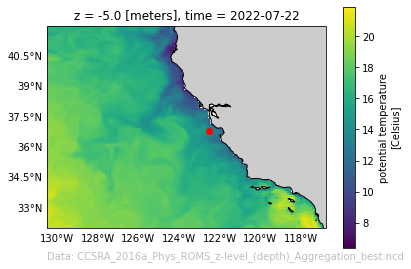

In [4]:
fig, ax = make_map()
roms_temp.isel(time=-1).plot(ax=ax,)
ax.text(x=0,y=-.15,s="Data: {}".format(url.split("/")[-1]),transform=ax.transAxes,size=10,color=".75")
plt.tight_layout()
ax.scatter(-122.5,36.8,color='r')
# plt.savefig("../figures/ts_temp_CAROMS.png", dpi=300,bbox_inches='tight',transparent=False)

__Get 1-D Data from a single Point__

In [5]:
stack_size = roms_temp.sel(latitude=36.8, longitude=-122.5).shape
print("Size of Temperature data: {}".format(stack_size)
chunk1 = roms_temp.sel(latitude=36.8, longitude=-122.5).isel(time=slice(0,2500)).load().to_pandas().to_frame()
chunk2 = roms_temp.sel(latitude=36.8, longitude=-122.5).isel(time=slice(2500,-1)).load().to_pandas().to_frame()

SyntaxError: invalid syntax (252004794.py, line 3)

In [ ]:
df = pd.concat((chunk1,chunk2))
df = df.rename(columns={0:'temp'})

In [ ]:
auto_fxn_adj = sm.tsa.acf(df['temp'], nlags=30, adjusted=True)
auto_fxn = sm.tsa.acf(df['temp'], nlags=30, adjusted=False)
fig, ax = plt.subplots()
ax.plot(auto_fxn)
ax.plot(auto_fxn_adj)


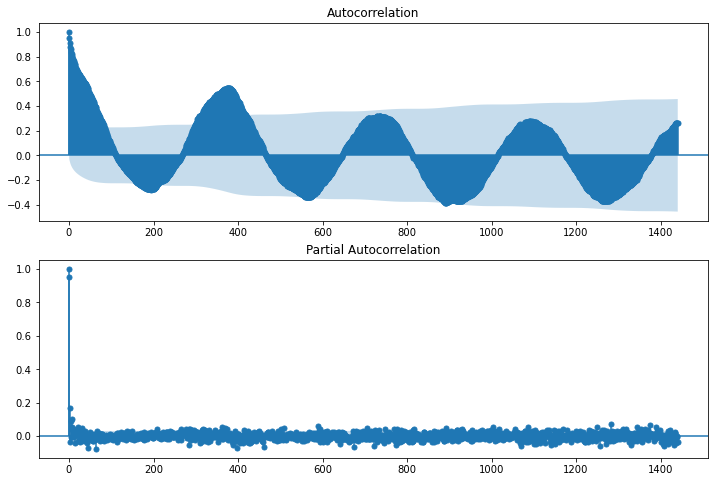

In [105]:
# plot_acf(df['temp'].values,lags=120)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.temp.values.squeeze(), lags=360*4, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.temp, lags=360*4, ax=ax2)


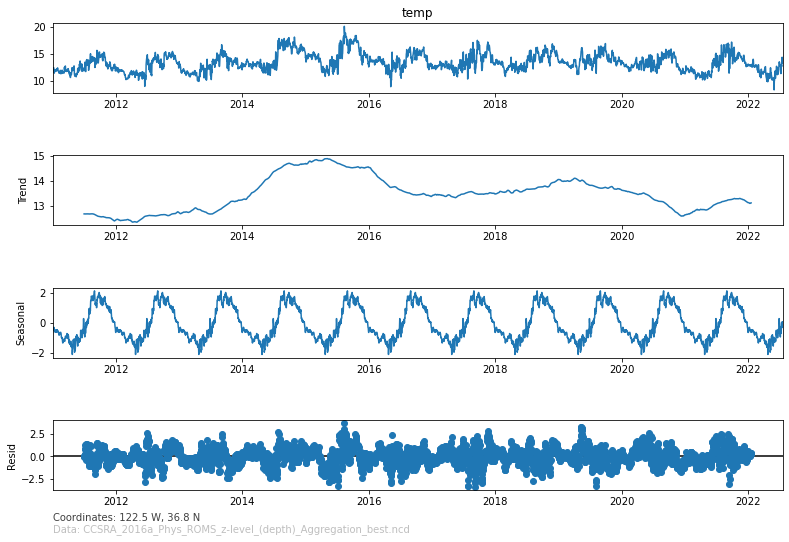

In [134]:
result = seasonal_decompose(df['temp'], model='additive', period=365)
fig = result.plot()
fig.set_size_inches(12,8)
plt.text(x=0,y=-.45,s="Coordinates: 122.5 W, 36.8 N",transform=plt.gca().transAxes,size=10,color=".25")
plt.text(x=0,y=-.6,s="Data: {}".format(url.split("/")[-1]),transform=plt.gca().transAxes,size=10,color=".75")
# plt.savefig( "../figures/temp_seasonality.png", dpi=300,bbox_inches='tight',transparent=False)
plt.show()

<AxesSubplot:xlabel='time'>

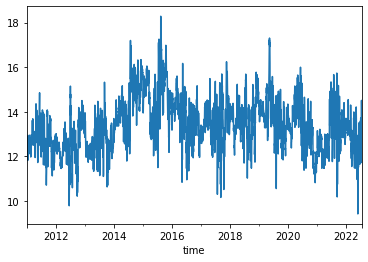

In [174]:
df['seasonal'] = seasonality = result.seasonal
df['normed'] = df['temp'] - df['seasonal']
df['normed'].plot()

In [182]:
df['doy'] = df.index.day_of_year
clim = df.groupby('doy')['temp'].mean()
df['clim'] = [ clim.loc[x] for x in df['doy'] ]
df['index'] = df['temp'] - df['clim']

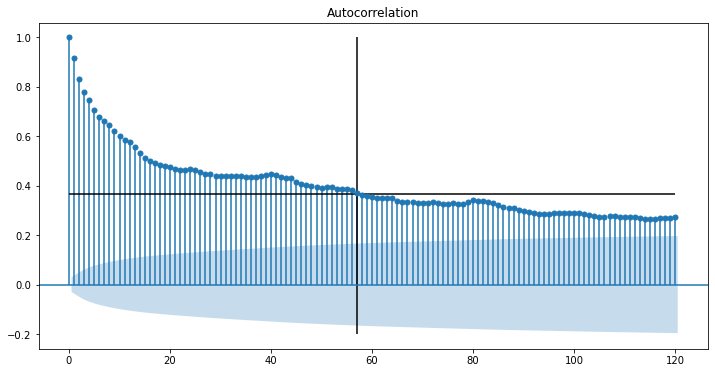

In [183]:
e_length = 1/np.e
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sm.graphics.tsa.plot_acf(df['index'].values.squeeze(), lags=120, ax=ax);
ax.hlines(y=e_length,xmin=0,xmax=120,color='k')
ax.vlines(x=57,ymin=-.2,ymax=1,color='k')

__ARMA Model Example__ - https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_arma_0.html 

In [ ]:


arma_mod20 = sm.tsa.statespace.SARIMAX(df.temp, order=(2,0,0), trend='c').fit(disp=False)
print(arma_mod20.params)
arma_mod30 = sm.tsa.statespace.SARIMAX(df.temp, order=(3,0,0), trend='c').fit(disp=False)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)


2.0285831897629745


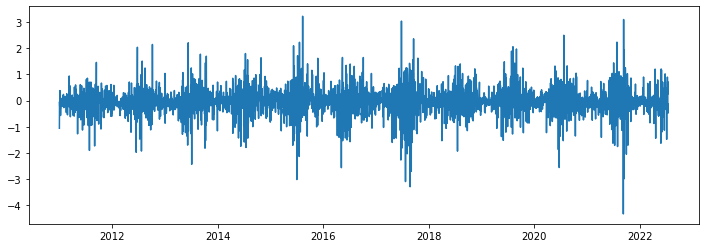

In [83]:
print(sm.stats.durbin_watson(arma_mod30.resid))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax = plt.plot(arma_mod30.resid)

In [84]:
resid = arma_mod30.resid

In [87]:
stats.normaltest(resid)

NormaltestResult(statistic=760.1665815956702, pvalue=8.549173735674955e-166)

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


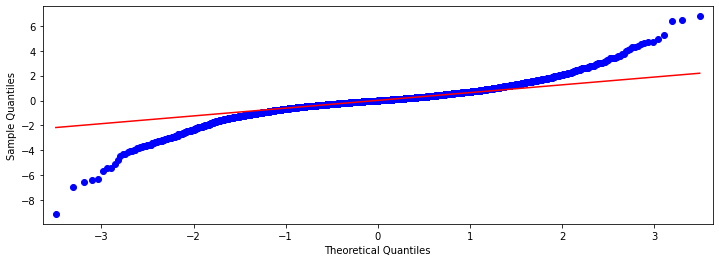

In [88]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

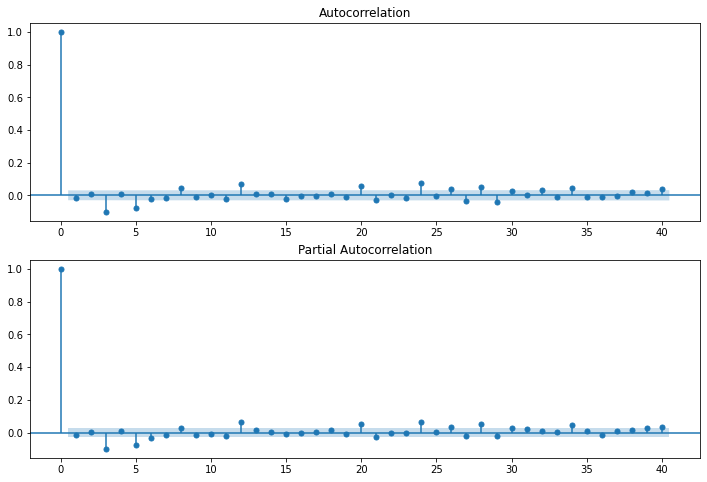

In [89]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [90]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[r[1:], q, p]
index = pd.Index(range(1,q.shape[0]+1), name="lag")
table = pd.DataFrame(data, columns=["AC", "Q", "Prob(>Q)"], index=index)
print(table)

           AC           Q      Prob(>Q)
lag                                    
1   -0.014888    0.934872  3.336001e-01
2    0.004956    1.038503  5.949656e-01
3   -0.099867   43.126488  2.313426e-09
4    0.009024   43.470187  8.265434e-09
5   -0.078231   69.309028  1.426916e-13
6   -0.022800   71.504389  2.008525e-13
7   -0.015704   72.546130  4.511391e-13
8    0.042661   80.235417  4.383474e-14
9   -0.008933   80.572680  1.243608e-13
10   0.001950   80.588745  3.848616e-13
11  -0.020538   82.372159  5.122874e-13
12   0.069976  103.080416  1.384466e-16
13   0.007612  103.325514  3.751663e-16
14   0.008077  103.601551  9.642151e-16
15  -0.022999  105.840036  1.009698e-15
16  -0.002140  105.859426  2.732862e-15
17  -0.004820  105.957783  6.917234e-15
18   0.010009  106.382038  1.478392e-14
19  -0.011295  106.922505  2.932646e-14
20   0.055434  119.943021  2.921635e-16
21  -0.029228  123.563625  1.579086e-16
22   0.002117  123.582618  3.881593e-16
23  -0.017541  124.887276  5.451479e-16


/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


In [100]:
predict_sunspots = arma_mod30.predict(start='2020', end='2024', dynamic=False)

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


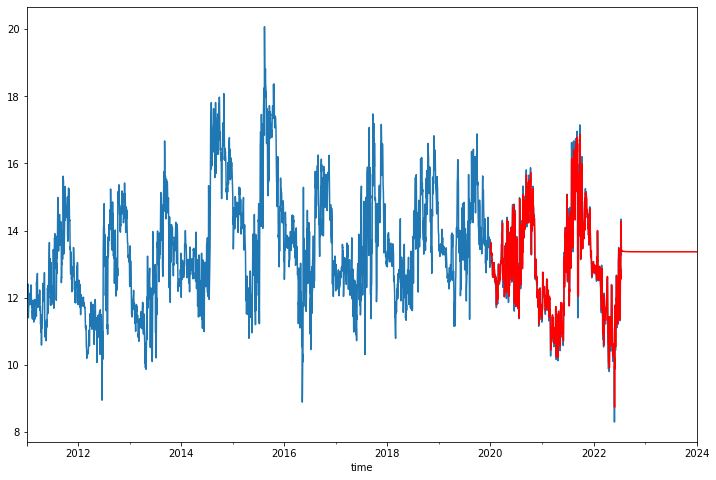

In [101]:
fig, ax = plt.subplots(figsize=(12, 8))
df.temp.plot(ax=ax)
predict_sunspots.plot(ax=ax, style='r');

In [102]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

mean_forecast_err(df.temp, predict_sunspots)

-0.018749565839855726

## Profiling the UCSC Thredds server ##

Basically, taking chunks of temperature records from a single depth around 2500 deep in time made the most sense

In [26]:
times = []
size = list(range(0,4001,250))
for n in size:
    time.sleep(1)
    start = time.time()
    off_mbar = roms_temp.sel(latitude=36.8, longitude=-122.5).isel(time=slice(0,n)).load()
    end = time.time()
    times.append(end - start)
    print("Slice Size: {} | Seconds: {}".format(n,end - start))



Slice Size: 0 | Seconds: 0.003351926803588867
Slice Size: 250 | Seconds: 3.507746934890747
Slice Size: 500 | Seconds: 6.271211862564087
Slice Size: 750 | Seconds: 9.24943733215332
Slice Size: 1000 | Seconds: 12.625139951705933
Slice Size: 1250 | Seconds: 15.379841804504395
Slice Size: 1500 | Seconds: 19.613314151763916
Slice Size: 1750 | Seconds: 23.236414909362793
Slice Size: 2000 | Seconds: 21.42711615562439
Slice Size: 2250 | Seconds: 28.8261821269989
Slice Size: 2500 | Seconds: 24.73875594139099
Slice Size: 2750 | Seconds: 31.63301682472229
Slice Size: 3000 | Seconds: 30.57317304611206
Slice Size: 3250 | Seconds: 30.966064929962158
Slice Size: 3500 | Seconds: 30.53527307510376
Slice Size: 3750 | Seconds: 31.15303611755371


oc_open: server error retrieving url: code=? message="Error {
    code = 404;
    message = "/proj/ocemod_web/storage/wc12.0_coamps_hycom_kpp_v737jpm_ra_tave24_01/phys_only/thredds/20210825_da_fwd_002_zlevs.nc (Too many open files)";
}"oc_open: server error retrieving url: code=? message="Error {
    code = 404;
    message = "/proj/ocemod_web/storage/wc12.0_coamps_hycom_kpp_v737jpm_ra_tave24_01/phys_only/thredds/20210825_da_fwd_002_zlevs.nc (Too many open files)";
}"oc_open: server error retrieving url: code=? message="Error {
    code = 404;
    message = "/proj/ocemod_web/storage/wc12.0_coamps_hycom_kpp_v737jpm_ra_tave24_01/phys_only/thredds/20210825_da_fwd_002_zlevs.nc (Too many open files)";
}"oc_open: server error retrieving url: code=? message="Error {
    code = 404;
    message = "/proj/ocemod_web/storage/wc12.0_coamps_hycom_kpp_v737jpm_ra_tave24_01/phys_only/thredds/20210825_da_fwd_002_zlevs.nc (Too many open files)";
}"oc_open: server error retrieving url: code=? message="Er

RuntimeError: NetCDF: file not found

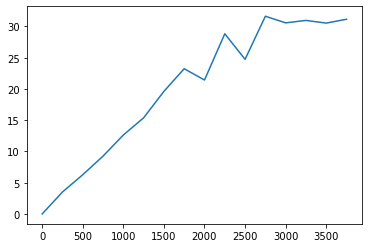

In [30]:
fig,ax = plt.subplots()
ax.plot(size[:-1],times)